In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


<Axes: title={'center': 'Emotion Distribution'}>

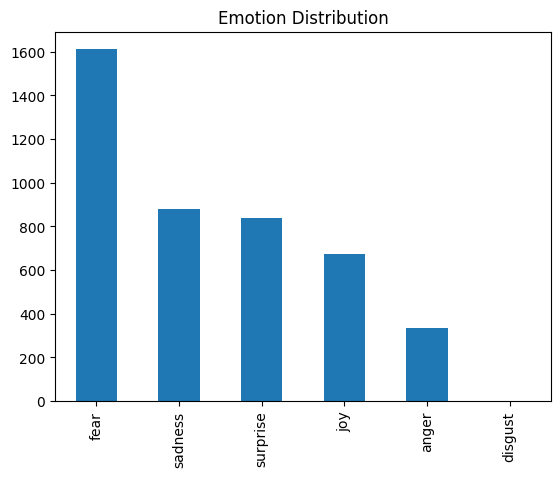

In [1]:
from datasets import load_dataset
import pandas as pd

#ds = load_dataset("BRIGHTER-emotion-categories", "eng", split="train")

dataset = load_dataset("brighter-dataset/BRIGHTER-emotion-categories", "eng")

df = pd.DataFrame(dataset['train'])

# Emotion frequency
emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
df[emotions].sum().sort_values(ascending=False).plot(kind='bar', title="Emotion Distribution")

In [ ]:
from transformers import  AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

label_names = ['joy', 'sadness', 'anger', 'fear', 'surprise']

# Initialize the model with the correct number of labels and problem type
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-small",
    num_labels=len(label_names),  
    problem_type="multi_label_classification",
    hidden_dropout_prob=0.3, 
    attention_probs_dropout_prob=0.3,
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")

def preprocess(example):
    # Tokenize text
    tokenized = tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)
    # Get labels
    tokenized["labels"] = [float(example[label]) for label in label_names]
    return tokenized

encoded_dataset = dataset.map(preprocess, batched=False)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/232 [00:00<?, ? examples/s]

In [3]:
from transformers import TrainingArguments, Trainer , EarlyStoppingCallback
import torch

def compute_metrics(eval_pred):
    from sklearn.metrics import f1_score
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    predictions = (probs > 0.5).astype(int)
    return {
        "f1_micro": f1_score(labels, predictions, average="micro"),
        "f1_macro": f1_score(labels, predictions, average="macro"),
    }

# Training arguments with regularization
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,  # Regularization
    num_train_epochs=10,
    logging_dir="./logs",
    logging_steps=10,
)

In [4]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer.train()

<ipython-input-4-2fe0a19970ca>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: naz500221 (naz500221-politecnico-di-torino) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.589600,0.566923,0.442217,0.143261
2,0.558100,0.505804,0.446492,0.160531
3,0.502400,0.472451,0.512085,0.302876
4,0.462700,0.429507,0.656367,0.524603
5,0.428900,0.423299,0.675943,0.567483
6,0.406900,0.414703,0.687384,0.611453
7,0.387500,0.425405,0.689917,0.629781
8,0.375600,0.424243,0.701819,0.648531
9,0.369100,0.419510,0.700367,0.644554
10,0.363000,0.415238,0.704717,0.653375


TrainOutput(global_step=1730, training_loss=0.44438290678696823, metrics={'train_runtime': 972.1428, 'train_samples_per_second': 28.473, 'train_steps_per_second': 1.78, 'total_flos': 916756094115840.0, 'train_loss': 0.44438290678696823, 'epoch': 10.0})

In [5]:
trainer.evaluate(encoded_dataset["test"])

{'eval_loss': 0.41523808240890503,
 'eval_f1_micro': 0.7047169811320755,
 'eval_f1_macro': 0.6533745106315542,
 'eval_runtime': 24.6055,
 'eval_samples_per_second': 224.909,
 'eval_steps_per_second': 14.062,
 'epoch': 10.0}

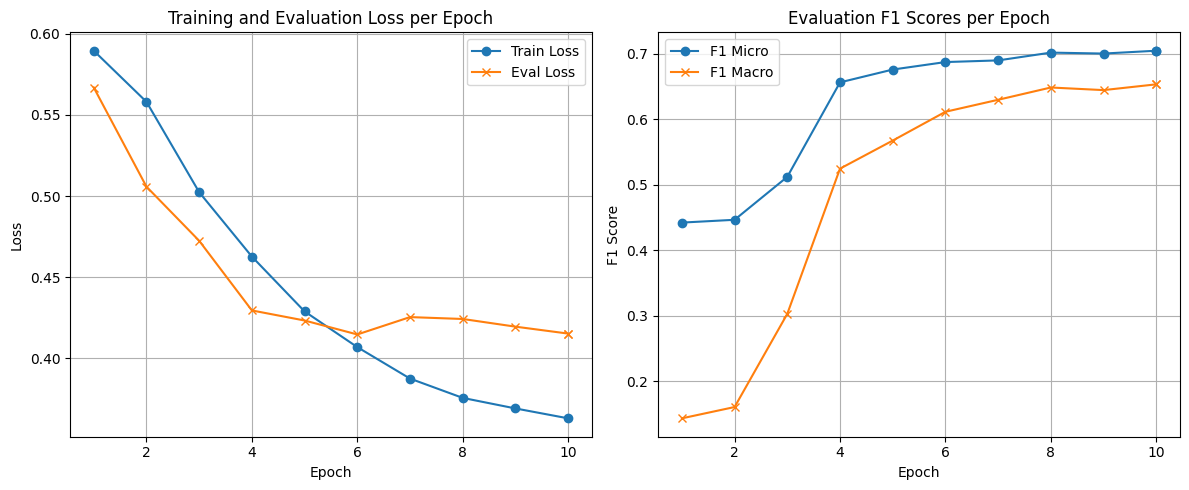

In [6]:
import matplotlib.pyplot as plt

# Extract log history (includes training and eval logs)
log_history = trainer.state.log_history

# Separate values
train_epochs = []
train_loss = []
eval_epochs = []
eval_loss = []
eval_f1_micro = []
eval_f1_macro = []

for log in log_history:
    if "eval_loss" in log:
        eval_epochs.append(log["epoch"])
        eval_loss.append(log["eval_loss"])
        eval_f1_micro.append(log["eval_f1_micro"])
        eval_f1_macro.append(log["eval_f1_macro"])
    if "loss" in log and "epoch" in log:
        train_epochs.append(log["epoch"])
        train_loss.append(log["loss"])

# Plot
plt.figure(figsize=(12, 5))

# Plot Training and Evaluation Loss
plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_loss, marker='o', label="Train Loss")
plt.plot(eval_epochs, eval_loss, marker='x', label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss per Epoch")
plt.grid(True)
plt.legend()

# Plot F1 Scores
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_f1_micro, marker='o', label="F1 Micro")
plt.plot(eval_epochs, eval_f1_macro, marker='x', label="F1 Macro")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Evaluation F1 Scores per Epoch")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


10 epochs , seems that after epoch 6 it doest learn so many things